# Quiz 3 - Noise Filtering

#### Edson Roteia Araujo Junior e João Pedro Moreira Ferreira

In [36]:
import cv2
import cmath
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Input Image

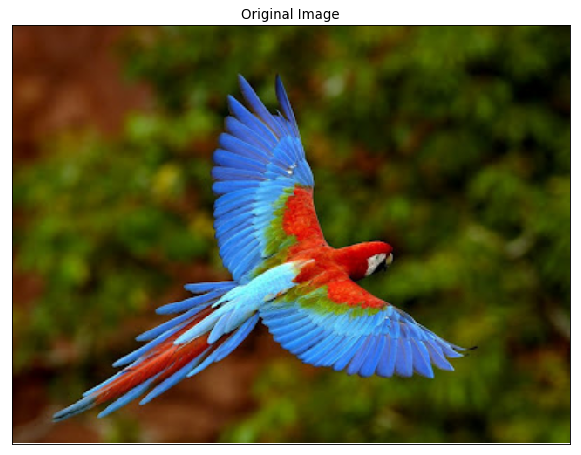

In [37]:
original = cv2.imread('imgs/parrot.jpg')
img = cv2.cvtColor(cv2.resize(original,(640,480)),cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Original Image') 
plt.show()

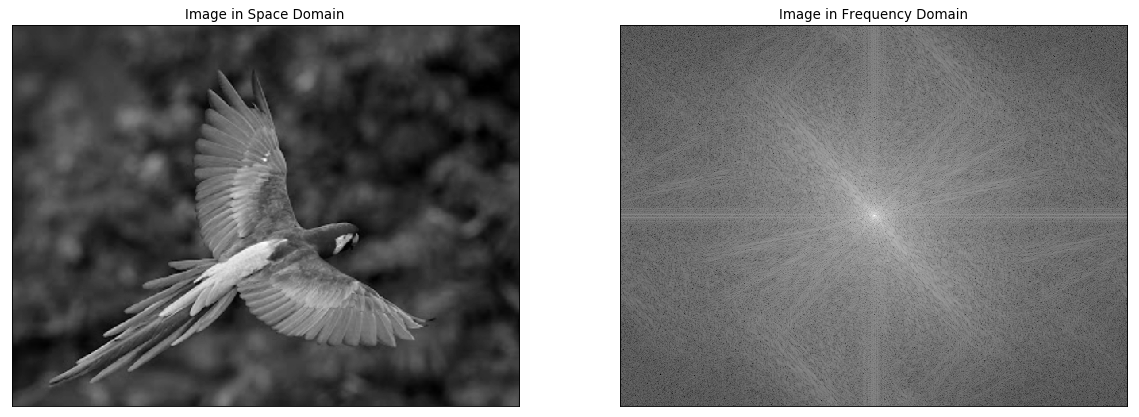

In [38]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
dft = cv2.dft(np.float32(img_gray),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img_gray, cmap = 'gray')
plt.title('Image in Space Domain'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Image in Frequency Domain'), plt.xticks([]), plt.yticks([])
plt.show()

## Our Low-pass Filter

#### We used the following equation to build the H matrices:
$$H(u,v) = \frac{1}{1+[D(u,v)/D_{0}]^{2n}}$$

$$D(u,v) = \sqrt{u^2 + v^2}$$

#### With the following values:

$H_{1}$
* $n = 40$
* $D_{0} = 128$

$H_{2}$
* $n = 1$
* $D_{0} = 1$

$H_{3}$
* $n = 4$
* $D_{0} = 10$

In [39]:
height, width = magnitude_spectrum.shape
n = 40.0#1 #4
D_0 = 128.0#1 #10

H1 = []
for u in range(int(-height/2), int(height/2)):
    H_line = []
    for v in range(int(-width/2), int(width/2)):
        H_line.append(1.0 / (1.0 + (np.sqrt(u ** 2 + v ** 2) / D_0) ** (2 * n)))
    H1.append(H_line)
H1 = np.array(H1)

n = 1.0 #4
D_0 = 1.0 #10
H2 = []
for u in range(int(-height/2), int(height/2)):
    H_line = []
    for v in range(int(-width/2), int(width/2)):
        H_line.append(1.0 / (1.0 + (np.sqrt(u ** 2 + v ** 2) / D_0) ** (2 * n)))
    H2.append(H_line)
H2 = np.array(H2)

n = 4.0
D_0 = 10.0
H3 = []
for u in range(int(-height/2), int(height/2)):
    H_line = []
    for v in range(int(-width/2), int(width/2)):
        H_line.append(1.0 / (1.0 + (np.sqrt(u ** 2 + v ** 2) / D_0) ** (2 * n)))
    H3.append(H_line)
H3 = np.array(H3)

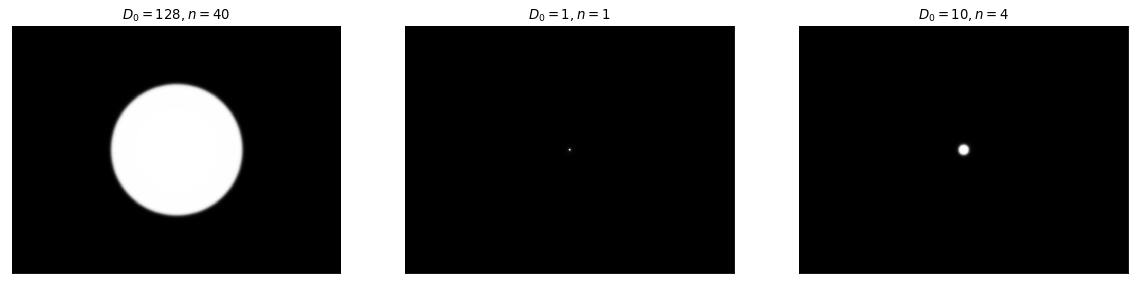

In [40]:
f1 = np.zeros(img.shape).astype(np.uint8)
f1[:,:,0] = (H1 * 255).astype(np.uint8)
f1[:,:,1] = (H1 * 255).astype(np.uint8)
f1[:,:,2] = (H1 * 255).astype(np.uint8)

f2 = np.zeros(img.shape).astype(np.uint8)
f2[:,:,0] = (H2 * 255).astype(np.uint8)
f2[:,:,1] = (H2 * 255).astype(np.uint8)
f2[:,:,2] = (H2 * 255).astype(np.uint8)

f3 = np.zeros(img.shape).astype(np.uint8)
f3[:,:,0] = (H3 * 255).astype(np.uint8)
f3[:,:,1] = (H3 * 255).astype(np.uint8)
f3[:,:,2] = (H3 * 255).astype(np.uint8)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(131),plt.imshow(f1)
plt.title('$D_0=128,n=40$'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(f2)
plt.title('$D_0=1,n=1$'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(f3)
plt.title('$D_0=10,n=4$'), plt.xticks([]), plt.yticks([])
plt.show()

## Creating the C matrix

We were based on the following equations to create the matrix C:

$$H(u,v) = \frac{1}{MN}\sum_{x=0}^{m-1}\sum_{y=0}^{n-1}h(x,y)e^{-i2\pi(\frac{xu}{M} + \frac{yu}{N})}$$
$$[H] = [C][h]$$

From these two relationships, it is possible to infer C's elements. We define them as follows:

$$C_{[u_{i} * vmax + v_{j}][x_{k} * fs + y_{l}]} = \frac{1}{MN}e^{-i2\pi(\frac{x_{k}u_{i}}{M} + \frac{y_{l}u_{i}}{N})}$$

Where $fs$ is the filter size (3 or 7, in our case).

We then build the matrix by iterating over the values of ${k, l}$ from $0$ to $fs - 1$, of $i$ from $0$ to the image width, and of $j$ from $0$ to the image height.

In [41]:
c_3 = np.zeros((img.shape[0]*img.shape[1],9),dtype=complex) 
for x in range(3):
     for y in range(3):
            for u in range(img.shape[0]):
                for v in range(img.shape[1]):
                    c_3[u*img.shape[1]+v][x*3+y] = (cmath.exp(-2j*cmath.pi*((x*u/float(img.shape[0]))+(y*v/float(img.shape[1])))))/img.shape[0]*img.shape[1]
c_7 = np.zeros((img.shape[0]*img.shape[1],49),dtype=complex) 
for x in range(7):
     for y in range(7):
            for u in range(img.shape[0]):
                for v in range(img.shape[1]):
                    c_7[u*img.shape[1]+v][x*7+y] = (cmath.exp(-2j*cmath.pi*((x*u/img.shape[0])+(y*v/img.shape[1]))))/img.shape[0]*img.shape[1]

## Getting the $\hat{h}$ matrices

Lastly, using the equation, we are able to obtain our $\hat{h}$s:

$$[\hat{h}] = ([C]*[C])^{-1}[C]*[H]$$

$([C]*[C])^{-1}[C]$ is the pseudoinverse of the matrix C that can be easily calculated using the numpy function **_np.linalg.pinv_**.


In [42]:
H3.shape = (img.shape[0]*img.shape[1],1)
H2.shape = (img.shape[0]*img.shape[1],1)
H1.shape = (img.shape[0]*img.shape[1],1)
h3_hat_3 = np.matmul(np.linalg.pinv(c_3),H3)
h2_hat_3 = np.matmul(np.linalg.pinv(c_3),H2)
h1_hat_3 = np.matmul(np.linalg.pinv(c_3),H1)

h3_hat_7 = np.matmul(np.linalg.pinv(c_7),H3)
h2_hat_7 = np.matmul(np.linalg.pinv(c_7),H2)
h1_hat_7 = np.matmul(np.linalg.pinv(c_7),H1)

h3_hat_3 = (cv2.normalize(h3_hat_3.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h3_hat_3 = h3_hat_3/np.sum(h3_hat_3)
h3_hat_3.shape = (3,3)

h2_hat_3 = (cv2.normalize(h2_hat_3.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h2_hat_3 = h2_hat_3/np.sum(h2_hat_3)
h2_hat_3.shape = (3,3)

h1_hat_3 = (cv2.normalize(h1_hat_3.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h1_hat_3 = h1_hat_3/np.sum(h1_hat_3)
h1_hat_3.shape = (3,3)



h3_hat_7 = (cv2.normalize(h3_hat_7.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h3_hat_7 = h3_hat_7/np.sum(h3_hat_7)
h3_hat_7.shape = (7,7)

h2_hat_7 = (cv2.normalize(h2_hat_7.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h2_hat_7 = h2_hat_7/np.sum(h2_hat_7)
h2_hat_7.shape = (7,7)

h1_hat_7 = (cv2.normalize(h1_hat_7.real, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F))
h1_hat_7 = h1_hat_7/np.sum(h1_hat_7)
h1_hat_7.shape = (7,7)



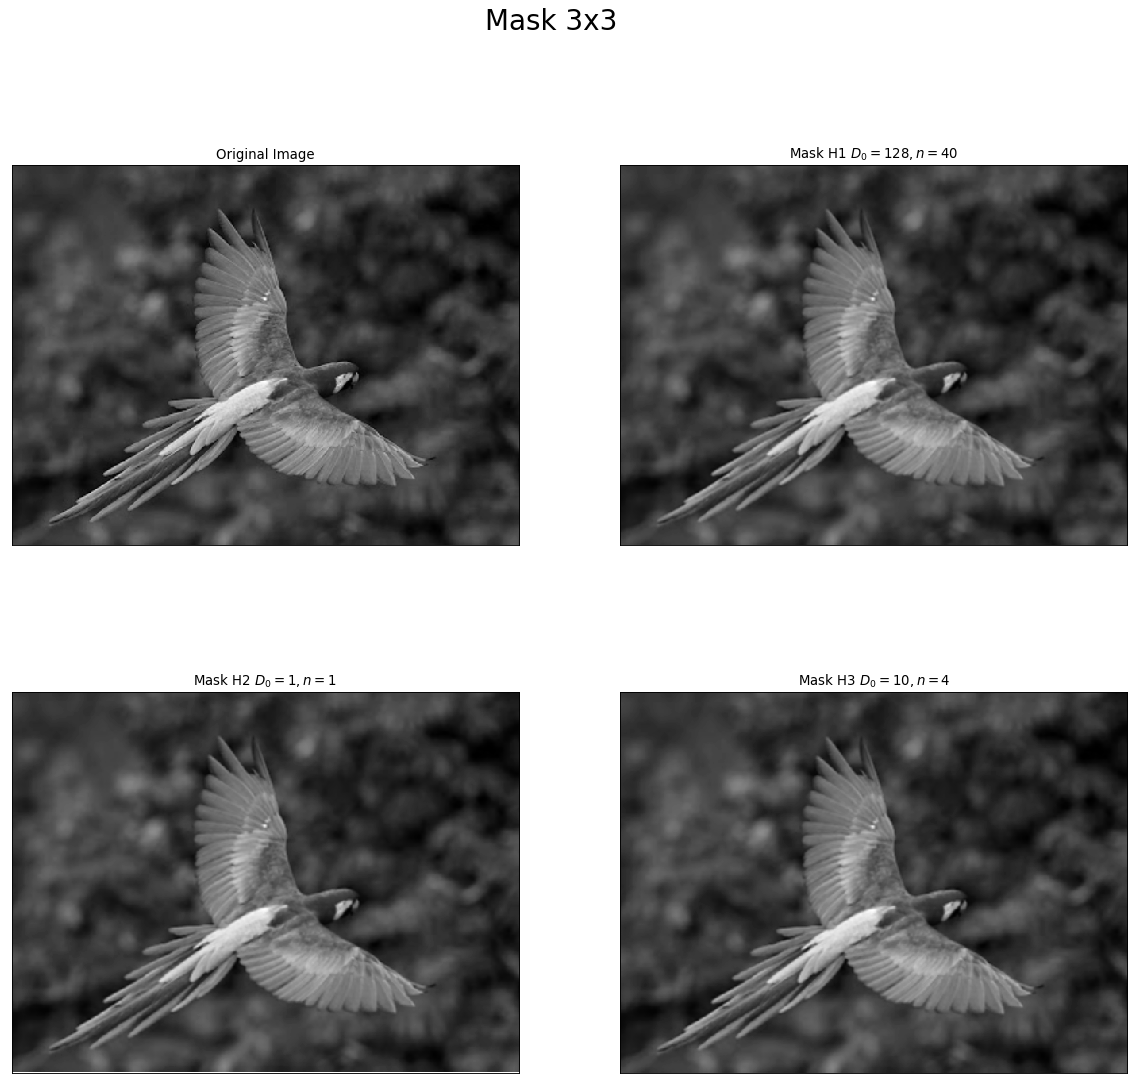

In [43]:
# filtred = cv2.filter2D(img_gray,-1,h1_hat_3)


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Mask 3x3',fontsize=25)
plt.subplot(221),plt.imshow(img_gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(cv2.filter2D(img_gray,-1,h1_hat_3), cmap='gray')
plt.title('Mask H1 $D_0=128,n=40$'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(cv2.filter2D(img_gray,-1,h2_hat_3), cmap='gray')
plt.title('Mask H2 $D_0=1,n=1$'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(cv2.filter2D(img_gray,-1,h3_hat_3), cmap='gray')
plt.title('Mask H3 $D_0=10,n=4$'), plt.xticks([]), plt.yticks([])
plt.show()

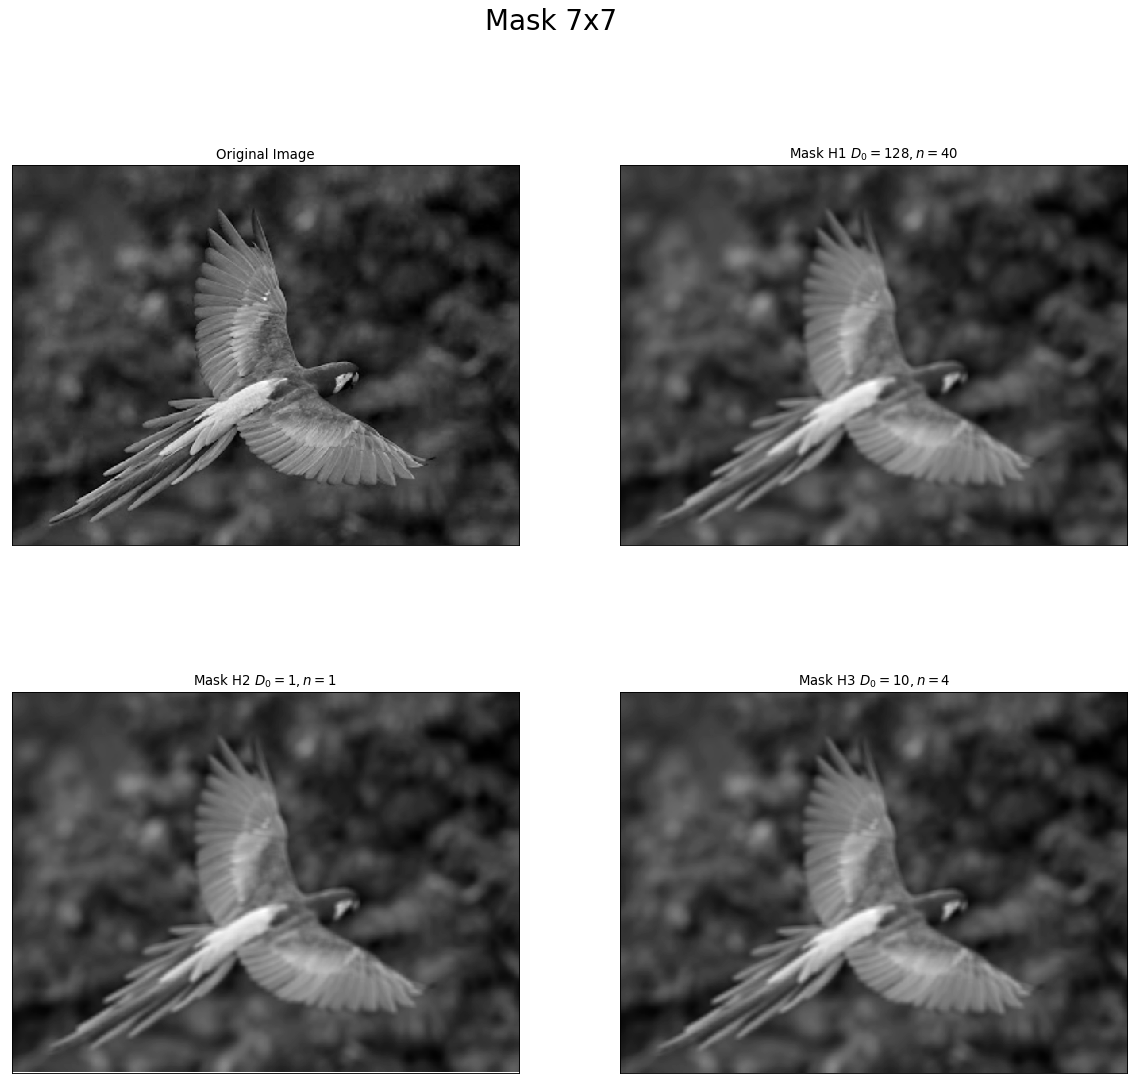

In [44]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Mask 7x7',fontsize=25)
plt.subplot(221),plt.imshow(img_gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(cv2.filter2D(img_gray,-1,h1_hat_7), cmap='gray')
plt.title('Mask H1 $D_0=128,n=40$'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(cv2.filter2D(img_gray,-1,h2_hat_7), cmap='gray')
plt.title('Mask H2 $D_0=1,n=1$'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(cv2.filter2D(img_gray,-1,h3_hat_7), cmap='gray')
plt.title('Mask H3 $D_0=10,n=4$'), plt.xticks([]), plt.yticks([])
plt.show()


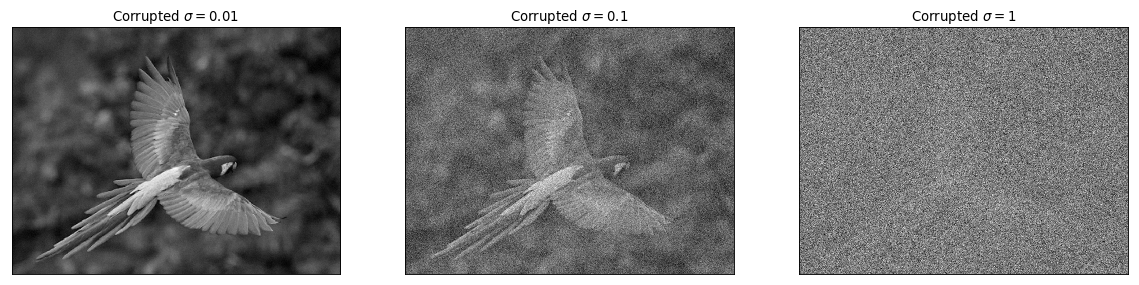

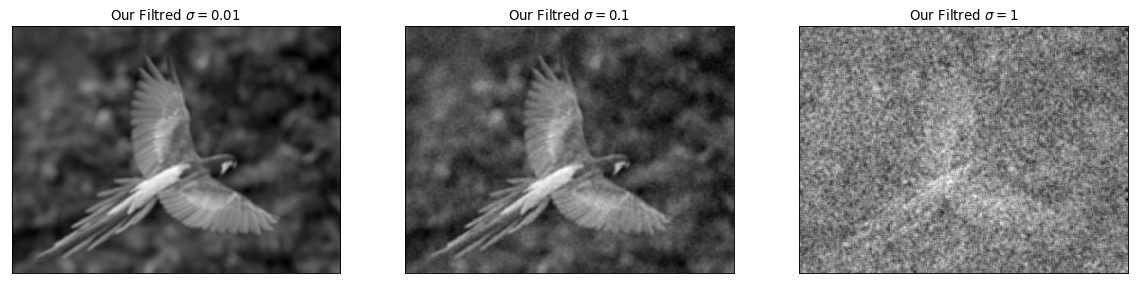

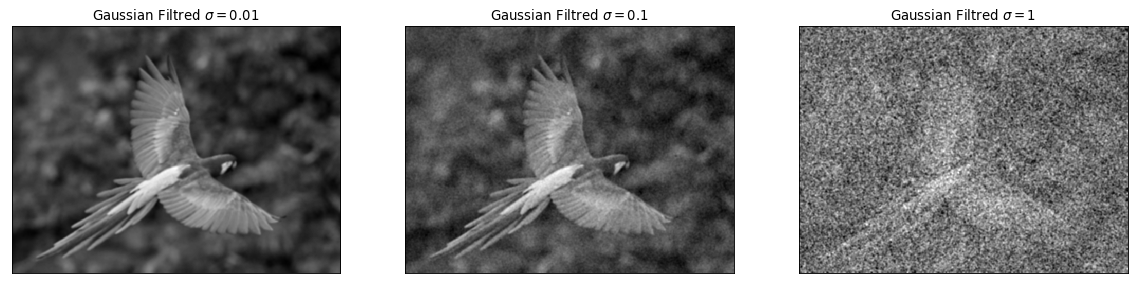

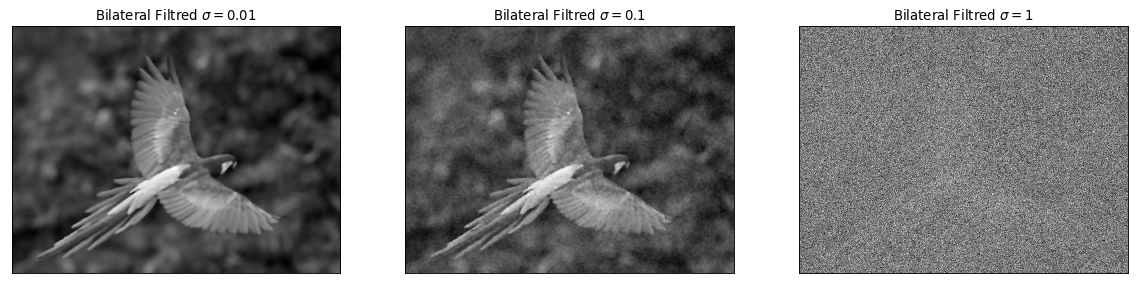

In [45]:
###corrupted images
noise_1 = img_gray+np.random.normal(0,1,(img_gray.shape[0],img_gray.shape[1]))*255
noise_01 = img_gray+np.random.normal(0,0.1,(img_gray.shape[0],img_gray.shape[1]))*255
noise_001 = img_gray+np.random.normal(0,0.01,(img_gray.shape[0],img_gray.shape[1]))*255

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(noise_001,cmap='gray')
plt.title('Corrupted $\sigma = 0.01$'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(noise_01,cmap='gray')
plt.title('Corrupted $\sigma = 0.1$'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(noise_1,cmap='gray')
plt.title('Corrupted $\sigma = 1$'), plt.xticks([]), plt.yticks([])
plt.show()

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(cv2.filter2D(noise_001,-1,h2_hat_7),cmap='gray')
plt.title('Our Filtred $ \sigma = 0.01$'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.filter2D(noise_01,-1,h2_hat_7),cmap='gray')
plt.title('Our Filtred $ \sigma = 0.1$'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.filter2D(noise_1,-1,h2_hat_7),cmap='gray')
plt.title('Our Filtred $ \sigma = 1$'), plt.xticks([]), plt.yticks([])
plt.show()

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(cv2.GaussianBlur(noise_001,(7,7),0),cmap='gray')
plt.title('Gaussian Filtred $ \sigma = 0.01$'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.GaussianBlur(noise_01,(7,7),0),cmap='gray')
plt.title('Gaussian Filtred $ \sigma = 0.1$'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.GaussianBlur(noise_1,(7,7),0),cmap='gray')
plt.title('Gaussian Filtred $ \sigma = 1$'), plt.xticks([]), plt.yticks([])
plt.show()

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(cv2.bilateralFilter(noise_001.astype(np.float32),7,75,75),cmap='gray')
plt.title('Bilateral Filtred $ \sigma = 0.01$'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.bilateralFilter(noise_01.astype(np.float32),7,75,75),cmap='gray')
plt.title('Bilateral Filtred $ \sigma = 0.1$'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.bilateralFilter(noise_1.astype(np.float32),7,75,75),cmap='gray')
plt.title('Bilateral Filtred $ \sigma = 1$'), plt.xticks([]), plt.yticks([])
plt.show()

## Second part

For the second part of this Quiz, we took 10 images from a camera with a fixed ISO so there exists enough noise in them. We then do the following:
* Compute the average image
* Compute the standard deviation
* Compute the average noise
* Use our mask to filter one of the image's noise out

In [46]:
images_name = ['imgs/0.jpg','imgs/1.jpg','imgs/2.jpg','imgs/3.jpg','imgs/4.jpg','imgs/5.jpg','imgs/6.jpg',
               'imgs/7.jpg','imgs/8.jpg','imgs/9.jpg']#,'imgs/10.jpg']
images = []
for img_name in images_name:
    images.append(cv2.cvtColor(cv2.resize(cv2.imread(img_name),(640,480)),cv2.COLOR_BGR2GRAY))

### Computing the average image

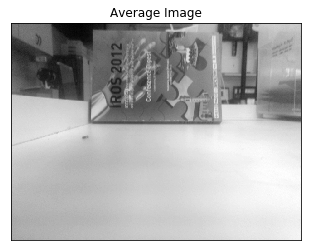

In [47]:
####AVERAGE IMAGE
average_img = np.mean(images,axis=0)
average_img = average_img.astype(int)
# average_img_rgb = average_img[:,:,::-1]
plt.imshow(average_img,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Average Image') 
plt.show()

### Computing the standard deviation

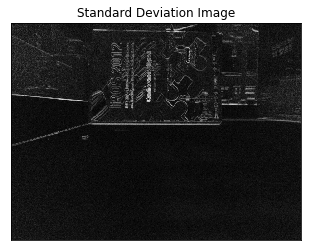

In [48]:
####STANDARD DEVIATION
std_img = np.sqrt(np.mean(abs(np.array(images) - average_img)**2,axis=0))
std_img = std_img.astype(int)
plt.imshow(std_img,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Standard Deviation Image') 
plt.show()

### Computing the average noise

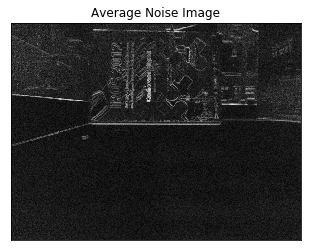

In [49]:
####AVERAGE NOISE
noise = (abs((np.array(images)-average_img))-std_img)
noise[noise < 0] = 0
noise = np.mean(noise,axis=0)
plt.imshow(noise,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Average Noise Image') 
plt.show()

### Using our mask to filter one of the image's noise out

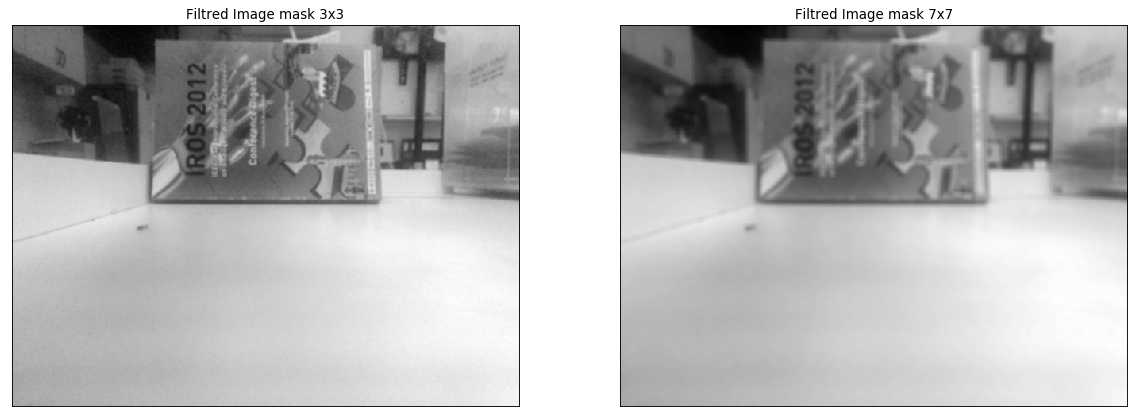

In [50]:
####FILTERING
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121),plt.imshow(cv2.filter2D(images[0],-1,h2_hat_3), cmap = 'gray')
plt.title('Filtred Image mask 3x3'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv2.filter2D(images[0],-1,h2_hat_7), cmap = 'gray')
plt.title('Filtred Image mask 7x7'), plt.xticks([]), plt.yticks([])
plt.show()

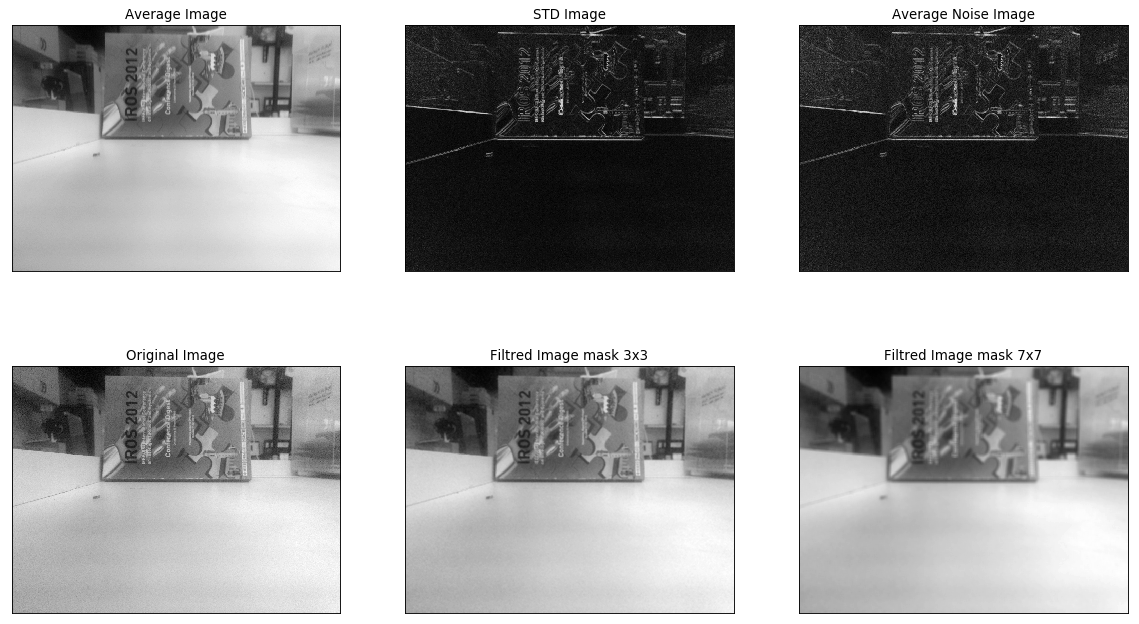

In [51]:
####all images
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(331),plt.imshow(average_img,cmap='gray')
plt.title('Average Image'), plt.xticks([]), plt.yticks([])
plt.subplot(332),plt.imshow(std_img,cmap='gray')
plt.title('STD Image'), plt.xticks([]), plt.yticks([])
plt.subplot(333),plt.imshow(noise,cmap='gray')
plt.title('Average Noise Image'), plt.xticks([]), plt.yticks([])
plt.subplot(334),plt.imshow(images[0],cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(335),plt.imshow(cv2.filter2D(images[0],-1,h2_hat_3),cmap='gray')
plt.title('Filtred Image mask 3x3'), plt.xticks([]), plt.yticks([])
plt.subplot(336),plt.imshow(cv2.filter2D(images[0],-1,h2_hat_7),cmap='gray')
plt.title('Filtred Image mask 7x7'), plt.xticks([]), plt.yticks([])
plt.show()